In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import time

Creating a dataframe with image url and label

In [2]:
root_directory = os.getcwd()

In [3]:
paper_url = root_directory + '\\paper'
rock_url = root_directory + '\\rock'
scissors_url = root_directory + '\\scissors'

In [5]:
os.chdir(paper_url)

In [44]:
value_dict = {0:'paper',1:'rock',2:'scissors'}

In [7]:
paper_images_names = os.listdir()

In [8]:
df = pd.DataFrame(paper_images_names, np.zeros((len(paper_images_names))))

In [9]:
os.chdir(rock_url)
rock_images_names = os.listdir()
df = df.append(pd.DataFrame(rock_images_names , np.ones((len(rock_images_names)))))

In [10]:
os.chdir(scissors_url)
scissors_images_names = os.listdir()
df = df.append(pd.DataFrame(scissors_images_names , np.ones((len(scissors_images_names))) * 2))

In [11]:
df['labels'] = df.index

In [12]:
df['labels'] = df['labels'].astype(int)

In [13]:
df.columns = ['images' , 'labels']

Importing the data

In [14]:
class RockPaperScissors(Dataset):
    def __init__(self,directory,df,transform = None):
        self.transform = transform
        self.df = df
        self.directory = directory
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        img_url = os.path.join(self.directory , 'everything' ,self.df.iloc[index,0])
        img = np.asarray(Image.open(img_url))
        label = torch.tensor(int(self.df.iloc[index,1]))
        
        if self.transform:
            img = self.transform(img)
        return img.to(device) , label.to(device)
        

In [15]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [16]:
dataset = RockPaperScissors(root_directory,df,transform)

train_split , test_split = torch.utils.data.random_split(dataset,[1458,730])

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
train_loader = DataLoader(dataset = train_split , batch_size = 8 , shuffle=True)
test_loader = DataLoader(dataset = test_split , batch_size = 8 , shuffle=True)

Using mobilenet pretrained model

In [19]:
model = torchvision.models.mobilenet_v2(pretrained=True)

In [20]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [21]:
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(in_features=1280 , out_features = 3 , bias=True)
model = model.to(device)

In [22]:
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[1].parameters(),lr=lr)

Training

In [23]:
start = time.perf_counter()
num_epochs = 30
loss_list = []
for epoch in range(num_epochs):
    for i, (x,y) in enumerate(train_loader):
        x,y = x.to(device) , y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 30 == 0:
            loss_list.append(loss.data)
end = time.perf_counter()

In [24]:
print(f'Training time = {end-start}')

Training time = 776.9457980000001


Text(0, 0.5, 'Cost')

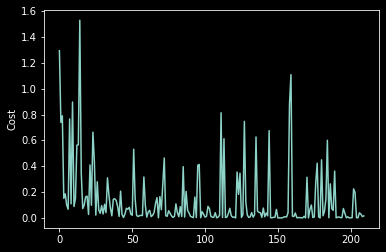

In [25]:
plt.style.use('dark_background')
plt.plot(loss_list)
plt.ylabel('Cost')

Testing

In [26]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for x,y in test_loader:
            x , y = x.to(device) , y.to(device)
            y_hat = model(x)
            _ , pred = y_hat.max(1)
            correct += (pred == y).sum()
            total += pred.shape[0]
    print(f'model score = {correct/total}')
    model.train()

model score = 0.9917808771133423
